In [1]:

import jax
import os



os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1.0'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
print(jax.local_devices())



import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy

from jax import random


import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

from scipy import integrate

import time

from jax.numpy import fft

from tqdm import tqdm

import math

from jax import grad

[cuda(id=0)]


In [2]:
# Testing the sine transform
def discrete_sine_transform(y):
    n = y.shape[0]
    y_extended = jnp.concatenate([y,  -y[::-1]])
    y_fft = fft.rfft(y_extended)
    return (-y_fft.imag/(jnp.sqrt(2)*(n)))[:-1] # Removing the last spurious element 

vmap_dst = jit(vmap(discrete_sine_transform, in_axes=(0,)))
@jit
def dst_2d(A):
    # Receives a 2d array and returns the 2d discrete sine transform
    return vmap_dst(vmap_dst(A).T).T


vmap_dst_2d = jit(vmap(dst_2d, in_axes = 0))#jit(vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1))
@jit
def double_dst_2d(A):
    # Transform along the last 2 axes
    A = vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1)(A)
    # Transpose the axes
    A = jnp.transpose(A, (2, 3, 0, 1))
    # Transform along the last 2 axes
    A = vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1)(A)
    # Transpose the axes (going back to the original order)
    A = jnp.transpose(A, (2, 3, 0,1))
    return A

# Defining the second order elliptic operators 
def matern_kernel_2d(x_1, x_2, y_1, y_2, length_scale):
    r =(x_1 - y_1) ** 2 + (x_2 - y_2) ** 2
    return jnp.exp(-r/length_scale)

In [3]:
length_scale = 1.0
matern_kernel_tensor = jit(vmap(vmap(vmap(vmap(matern_kernel_2d, in_axes=(None, None,None, 0, None)), in_axes=(None, None, 0, None, None)), in_axes = (None, 0, None, None, None)), in_axes=(0, None, None, None, None)))

# 2D Elliptic PDE

In [4]:
lower = 0.0
upper = 1.0
domain = jnp.array([lower,upper])

# 2d grid 
n_points = 128
x = jnp.linspace(lower, upper, n_points, endpoint=False)
y = jnp.linspace(lower, upper, n_points, endpoint=False)
X, Y = jnp.meshgrid(x, y)

In [5]:
K_tensor = matern_kernel_tensor(x, x, y, y, length_scale)
K_tensor_transform = double_dst_2d(K_tensor)
K_tensor.shape, K_tensor_transform.shape

((128, 128, 128, 128), (128, 128, 128, 128))

We will consider 


We will solve the elliptic PDE with Dirichlet bc
\begin{aligned}
-\Delta u + u&= \xi \\
u &= 0
\end{aligned}

We will consider a manufactured solution

\begin{aligned}
u = \sum_{k=1}^\infty\sum_{l=1}^\infty u_{kl} \sin(2\pi k x) \sin(2\pi l y) \quad  u_{kl} \sim \mathcal{N}(0, 1)
\end{aligned}

Then 

$$
\xi =  \sum_{k=1}^\infty\sum_{l=1}^\infty u_{kl}(l^2 + k^2)^{-\alpha -\delta}(4\pi^2(l^2 + k^2) + 1)\sin(2\pi k x) \sin(2\pi l y)


In [6]:
#plt.style.use('default')
plt.style.use('plot_style-Examples_3d.txt')

# 16:9 aspect ratio
width = 4
height = width * 3 / 4

In [7]:
def evaluate_function_sine_2d(x, y, k,l ,c):
    values = c*jnp.outer(jnp.sqrt(2)*jnp.sin(jnp.pi*k*x), jnp.sqrt(2)*jnp.sin(jnp.pi*l*y))
    values = jnp.where(k==0, c*jnp.outer(jnp.ones_like(x), jnp.sqrt(2)*jnp.sin(jnp.pi*l*y)), values)
    values = jnp.where(l==0, c*jnp.outer(jnp.sqrt(2)*jnp.sin(jnp.pi*k*x), jnp.ones_like(y)), values)
    return values

In [8]:
def evaluate_basis_sine_2d(x,y,c):
    # The frequency starts at 0
    f_1 = jnp.arange(0, c.shape[0])
    f_2 = jnp.arange(0, c.shape[0])
    return jnp.sum(jit(vmap(vmap(evaluate_function_sine_2d, in_axes=(None,None,0,None, 0), out_axes= -1), in_axes= (None, None, None, 0, 1),out_axes= -1))(x, y,f_1, f_2, c), axis = (2,3))#jit(vmap(vmap(evaluate_function_sine_2d, in_axes=(None,None,None,0, 1)), in_axes= (None, None, 0, None, 0)))(x, y,f_1, f_2, c)#vmap(evaluate_function_sine_2d, in_axes=(None,None,0,0, 0))(x, y,f_1, f_2, c)


def evaluate_function_sine_2d_iterative(x,y,c):
    values = jnp.zeros_like(jnp.outer(x, y))
    for k in range(c.shape[0]):
        for l in range(c.shape[1]):
            values += c[k,l]*jnp.outer(jnp.sqrt(2)*jnp.sin(jnp.pi*k*x), jnp.sqrt(2)*jnp.sin(jnp.pi*l*y))
    return values

In [686]:
key = random.PRNGKey(647023)
n_coef = 2**7
print("Number of coefficients: ", n_coef)

nu = 1e-2
b = 0.0


x_finest = jnp.linspace(lower,upper,n_coef, endpoint=False)
y_finest = jnp.linspace(lower,upper,n_coef, endpoint=False)
X, Y = jnp.meshgrid(x_finest, y_finest)
frequencies = jnp.arange(0, n_coef)

delta = .25
alpha = 2.0
random_draw =  random.normal(key, shape= (n_coef,n_coef))
decay = (jnp.arange(0,n_coef)[None] + jnp.arange(0,n_coef)[:,None])**2
coef_u =random_draw*(decay)**(-alpha -delta)
coef_u= coef_u.at[:,0].set(0)
coef_u= coef_u.at[0,:].set(0)
coef_f =coef_u*((nu*4*jnp.pi**2*decay) +b)


Number of coefficients:  128


In [687]:
u_values = evaluate_basis_sine_2d(x_finest,y_finest, coef_u)
f_values =evaluate_basis_sine_2d(x_finest,y_finest, coef_f)

In [688]:
# u_values = evaluate_function_sine_2d_iterative(x_finest,y_finest, coef_u)
# f_values = evaluate_function_sine_2d_iterative(x_finest,y_finest, coef_f)

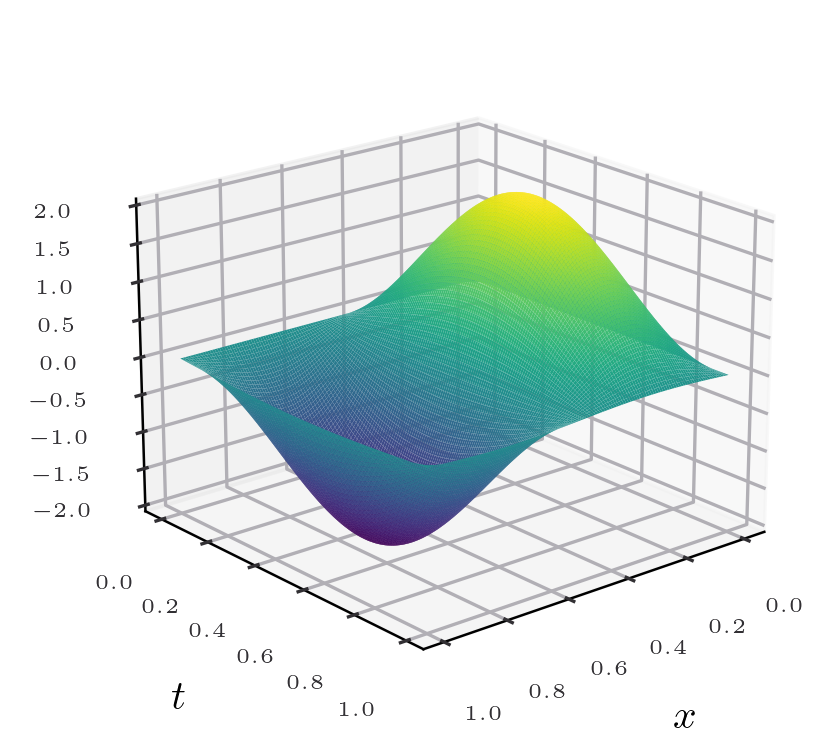

In [689]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, evaluate_function_sine_2d(x_finest, y_finest, 1,2 ,1),  cmap='viridis', rstride=stride, cstride=stride)
ax.view_init(elev=20, azim=50)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$')
plt.show()

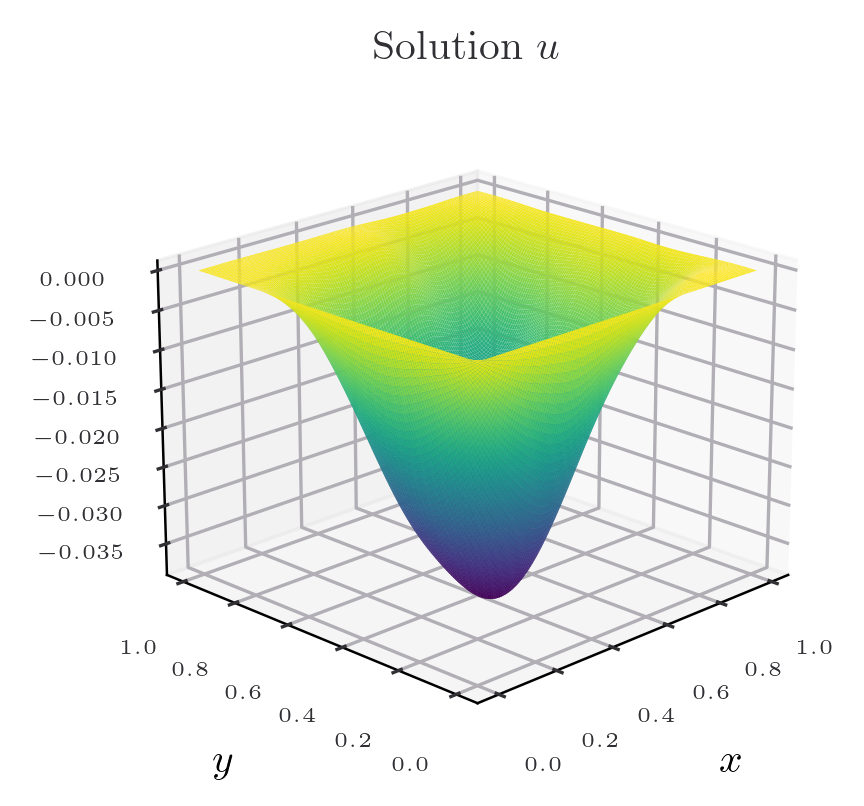

In [690]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_values,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Solution $u$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

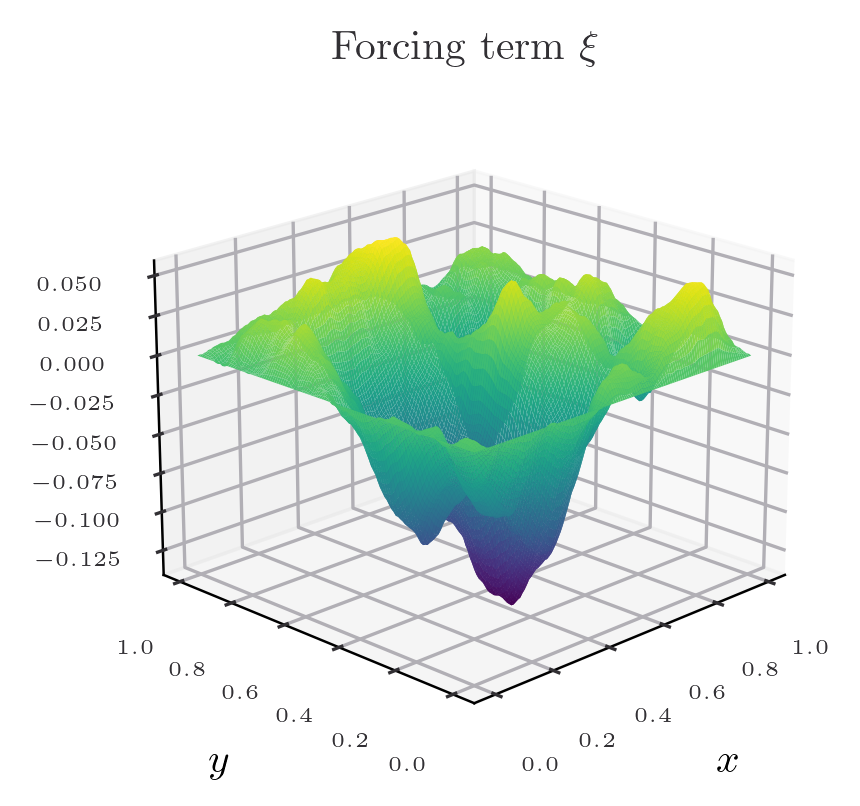

In [691]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, f_values,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Forcing term $\xi$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

In [692]:
u_trans = dst_2d(u_values)
f_trans = dst_2d(f_values)

In [693]:
jnp.mean(jnp.abs(u_trans - coef_u)), jnp.mean(jnp.abs(f_trans - coef_f))

(Array(1.54423091e-07, dtype=float64), Array(3.87705375e-06, dtype=float64))

In [694]:
i,j, k,l = 10,2,0,0
test_values = jnp.outer(jnp.sqrt(2)*jnp.sin(jnp.pi*k*x_finest), jnp.sqrt(2)*jnp.sin(jnp.pi*l*x_finest)) + 0.5*jnp.outer(jnp.sqrt(2)*jnp.sin(jnp.pi*i*x_finest), jnp.sqrt(2)*jnp.sin(jnp.pi*j*x_finest))

In [695]:
dst_2d(test_values)[k,l], dst_2d(test_values)[i,j]

(Array(-0., dtype=float64), Array(0.49221119, dtype=float64))

# Solve the linear PDE

In [696]:
lower = 0.0
upper = 1.0
domain = jnp.array([lower,upper])


# 2d grid 
n_points = 2**5
print("Number of points {} ({} measurements)".format(n_points, n_points**2))
x = jnp.linspace(lower, upper, n_points, endpoint=False)
y = jnp.linspace(lower, upper, n_points, endpoint=False)
X, Y = jnp.meshgrid(x, y)

Number of points 32 (1024 measurements)


In [697]:
# Use meshgrid to create the grid of pairs
A, B = jnp.meshgrid(x, x, indexing='ij')

# Combine A and B into pairs
interior = jnp.stack((A, B), axis=-1).reshape(-1, 2)
print(interior.shape)

(1024, 2)


In [698]:
# Create the boundary
n_boundary = 2**6
print("Number of boundary points: {} ({} total)".format(n_boundary, n_boundary*4))

# Create a boundary
# Boundary points
boundary = jnp.linspace(0,1, n_boundary)

boundary_points = []
# Creat a discretization of the boundary
for i in [0,1]:
    boundary_points.append(jnp.stack([jnp.zeros(n_boundary) + i, boundary], axis=-1))
for i in [0,1]:
    boundary_points.append(jnp.stack([boundary, jnp.zeros(n_boundary) + i], axis=-1))
    

boundary_points = jnp.concatenate(boundary_points, axis=0)
boundary_condition = jnp.zeros(shape = boundary_points.shape[0])

Number of boundary points: 64 (256 total)


In [699]:
def matern_kernel(x, y, length_scale):
    r =jnp.sum((x - y) ** 2)
    return jnp.exp(-r/length_scale)

vmap_kernel_row = vmap(matern_kernel, in_axes=(None, 0, None))
# Now we apply vmap to the result to vectorize over the rows of the first argument
vmap_kernel = jit(vmap(vmap_kernel_row, in_axes=(0, None, None)))

# Defining the second order elliptic operators 
def matern_kernel_2d(x_1, x_2, y_1, y_2, length_scale):
    r =(x_1 - y_1) ** 2 + (x_2 - y_2) ** 2
    return  jnp.exp(-r/length_scale)

matern_kernel_tensor = jit(vmap(vmap(vmap(vmap(matern_kernel_2d, in_axes=(None, None,None, 0, None)), in_axes=(None, None, 0, None, None)), in_axes = (None, 0, None, None, None)), in_axes=(0, None, None, None, None)))

In [700]:
def neg_laplacian_x(x_1, x_2, y_1, y_2, length_scale):
    l_1 = grad(grad(matern_kernel_2d, argnums=0), argnums = 0)(x_1, x_2, y_1, y_2, length_scale)
    l_2 = grad(grad(matern_kernel_2d, argnums=1), argnums = 1)(x_1, x_2, y_1, y_2, length_scale)
    return -(l_1 + l_2)

def neg_laplacian_y(x_1, x_2, y_1, y_2, length_scale):
    l_1 = grad(grad(matern_kernel_2d, argnums=2), argnums = 2)(x_1, x_2, y_1, y_2, length_scale)
    l_2 = grad(grad(matern_kernel_2d, argnums=3), argnums = 3)(x_1, x_2, y_1, y_2, length_scale)
    return -(l_1 + l_2)

def double_neg_laplacian(x_1, x_2, y_1, y_2, length_scale):
    l_1 = grad(grad(neg_laplacian_x, argnums=2), argnums = 2)(x_1, x_2, y_1, y_2, length_scale)
    l_2 = grad(grad(neg_laplacian_x, argnums=3), argnums = 3)(x_1, x_2, y_1, y_2, length_scale)

    return -(l_1 + l_2)

In [701]:
def L_b_x(x_1, x_2, y_1, y_2, length_scale, epsilon, b_x):
    return epsilon*neg_laplacian_x(x_1, x_2, y_1, y_2, length_scale) + b_x*matern_kernel_2d(x_1, x_2, y_1, y_2, length_scale)

def L_b_y(x_1, x_2, y_1, y_2, length_scale, epsilon, b_y):
    return epsilon*neg_laplacian_y(x_1, x_2, y_1, y_2, length_scale) + b_y*matern_kernel_2d(x_1, x_2, y_1, y_2, length_scale)

def L_b_xy(x_1, x_2, y_1, y_2, length_scale, epsilon, b_x, b_y):
    return epsilon**2*double_neg_laplacian(x_1, x_2, y_1, y_2, length_scale) + epsilon*b_y*neg_laplacian_x(x_1, x_2, y_1, y_2, length_scale) + epsilon*b_x*neg_laplacian_y(x_1, x_2, y_1, y_2, length_scale)+ b_x*b_y*matern_kernel_2d(x_1, x_2, y_1, y_2, length_scale)

L_b_xy_tensor = jit(vmap(vmap(vmap(vmap(L_b_xy, in_axes=(None, None,None, 0, None, None, None, None)), in_axes=(None, None, 0, None, None, None, None, None)), in_axes = (None, 0, None, None, None, None, None, None)), in_axes=(0, None, None, None, None, None, None, None)))
L_b_y_tensor_partial =vmap(vmap(vmap(L_b_y, in_axes=(None, None,None, 0, None, None, None)), in_axes=(None, None, 0, None, None, None, None)), in_axes = (0, 0, None, None, None, None, None))

L_b_y_tensor =vmap(vmap(vmap(vmap(L_b_y, in_axes=(None, None,None, 0, None, None, None)), in_axes=(None, None, 0, None, None, None, None)), in_axes = (None, 0, None, None, None, None, None)), in_axes = (0, None, None, None, None, None, None))


In [702]:
length_scale = 1.0

In [703]:
x.shape

(32,)

In [704]:
matern_kernel_2d(x[1], x[2], y[90], y[8], length_scale), matern_kernel(jnp.array([x[1], x[2]]), jnp.array([y[90], y[8]]) , length_scale)

(Array(0.40089229, dtype=float64), Array(0.40089229, dtype=float64))

In [705]:
theta_11 = vmap_kernel(boundary_points, boundary_points, length_scale)
theta_22_tensor = L_b_xy_tensor(x, x, y, y, length_scale, nu, b,b)
theta_12_tensor = L_b_y_tensor_partial(boundary_points[:, 0], boundary_points[:, 1], y, y, length_scale, nu, b)

theta_22_dst_tensor = double_dst_2d(theta_22_tensor)
theta_12_dst_tensor  = vmap_dst_2d(theta_12_tensor)

theta_12_dst = jnp.reshape(theta_12_dst_tensor, (n_boundary*4,n_points*n_points))
theta_22_dst = jnp.reshape(theta_22_dst_tensor, shape= ( n_points*n_points, n_points*n_points))


In [706]:
theta = jnp.block([[theta_11, theta_12_dst], [theta_12_dst.T, theta_22_dst]])
theta.shape

(1280, 1280)

In [707]:
jnp.linalg.eigh(theta)[0][0] # This is (almost) positive definite!!

Array(-2.68233056e-14, dtype=float64)

In [708]:
rhs = jnp.hstack([boundary_condition, jnp.reshape(coef_f[:n_points, :n_points], (n_points*n_points))])

# Solve the linear system
reg = 1e-8
nugget = jnp.hstack([jnp.ones(boundary_condition.shape[0])*1e-10, jnp.ones(n_points*n_points)*reg])
nugget

Array([1.e-10, 1.e-10, 1.e-10, ..., 1.e-08, 1.e-08, 1.e-08], dtype=float64)

In [709]:
alpha = scipy.linalg.solve(theta + jnp.diag(nugget), rhs, assume_a='pos')
#alpha = scipy.linalg.solve(theta + 1e-12*jnp.eye(theta.shape[0]), rhs, assume_a='pos')

In [710]:
meas = theta@alpha
print("Relative error: ", jnp.linalg.norm(rhs - meas)/jnp.linalg.norm(rhs))

Relative error:  0.5151338479717638


In [711]:
n_eval = 64
x_eval = jnp.linspace(lower, upper, n_eval)
X, Y = jnp.meshgrid(x_eval, x_eval)

# Use meshgrid to create the grid of pairs
A, B = jnp.meshgrid(x_eval, x_eval, indexing='ij')

# Combine A and B into pairs
interior_eval = jnp.stack((A, B), axis=-1).reshape(-1, 2)
print(interior_eval.shape)

(4096, 2)


In [712]:
b, nu, length_scale

(0.0, 0.01, 1.0)

In [713]:
K_interior = L_b_y_tensor(x_eval, x_eval, y, y, length_scale, nu, b).reshape(n_eval*n_eval, n_points, n_points)
K_interior = vmap_dst_2d(K_interior)
K_interior = K_interior.reshape(-1, n_points*n_points)
K_eval_bc = vmap_kernel(interior_eval, boundary_points, length_scale)

In [714]:
# def predict(x_eval, y_eval):
#     X, Y = jnp.meshgrid(x_eval, y_eval)
#     # Use meshgrid to create the grid of pairs
#     A, B = jnp.meshgrid(x_eval, y_eval, indexing='ij')
#     # Combine A and B into pairs
#     interior_eval = jnp.stack((A, B), axis=-1).reshape(-1, 2)


#     K_interior = L_b_y_tensor(x_eval, y_eval, y, y, length_scale, nu, b).reshape(n_eval*n_eval, n_points, n_points)
#     K_interior = vmap_dst_2d(K_interior)
#     K_interior = K_interior.reshape(-1, n_points*n_points)
#     K_eval_bc = vmap_kernel(interior_eval, boundary_points, length_scale)
#     K_eval = jnp.hstack([K_eval_bc, K_interior])
#     return K_eval@alpha

In [715]:
# pred = predict(x_eval, x_eval)
# pred_grid = jnp.reshape(pred, (n_eval, n_eval))

In [716]:
K_eval = jnp.hstack([K_eval_bc, K_interior])
pred = jnp.dot(K_eval, alpha)
pred_grid = jnp.reshape(pred, (n_eval, n_eval))

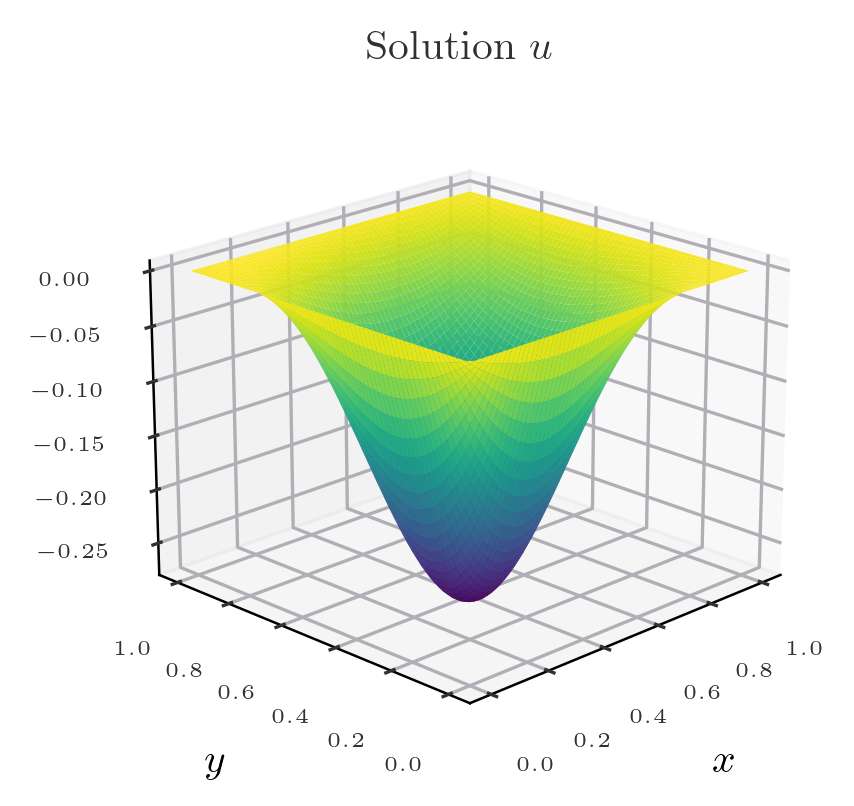

In [717]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, pred_grid,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Solution $u$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

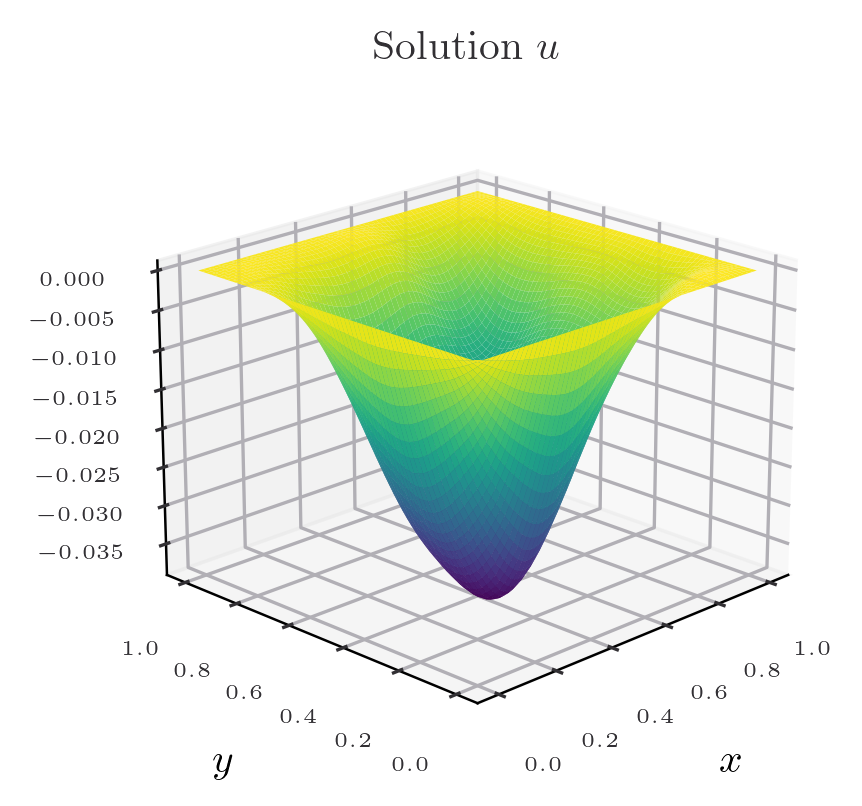

In [718]:
u_coarse =  evaluate_basis_sine_2d(x_eval,x_eval, coef_u)
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_coarse,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Solution $u$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

# Solve the linear PDE

In [39]:
lower = 0.0
upper = 1.0
domain = jnp.array([lower,upper])

length_scale = 1.0

# 2d grid 
n_points = 2**5
print("Number of points: ", n_points)
x = jnp.linspace(lower, upper, n_points, endpoint=False)
y = jnp.linspace(lower, upper, n_points, endpoint=False)
X, Y = jnp.meshgrid(x, y)

Number of points:  32


In [89]:
n_boundary = 2**4
print("Number of boundary points: {} ({} total)".format(n_boundary, n_boundary*4))

# Create a boundary
# Boundary points
boundary = jnp.linspace(0,1, n_boundary)

boundary_points = []
# Creat a discretization of the boundary
for i in [0,1]:
    boundary_points.append(jnp.stack([jnp.zeros(n_boundary) + i, boundary], axis=-1))
for i in [0,1]:
    boundary_points.append(jnp.stack([boundary, jnp.zeros(n_boundary) + i], axis=-1))
    

boundary_points = jnp.concatenate(boundary_points, axis=0)
boundary_condition = jnp.zeros(shape = boundary_points.shape[0])

Number of boundary points: 16 (64 total)


In [41]:
boundary_points

Array([[0.        , 0.        ],
       [0.        , 0.06666667],
       [0.        , 0.13333333],
       [0.        , 0.2       ],
       [0.        , 0.26666667],
       [0.        , 0.33333333],
       [0.        , 0.4       ],
       [0.        , 0.46666667],
       [0.        , 0.53333333],
       [0.        , 0.6       ],
       [0.        , 0.66666667],
       [0.        , 0.73333333],
       [0.        , 0.8       ],
       [0.        , 0.86666667],
       [0.        , 0.93333333],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.06666667],
       [1.        , 0.13333333],
       [1.        , 0.2       ],
       [1.        , 0.26666667],
       [1.        , 0.33333333],
       [1.        , 0.4       ],
       [1.        , 0.46666667],
       [1.        , 0.53333333],
       [1.        , 0.6       ],
       [1.        , 0.66666667],
       [1.        , 0.73333333],
       [1.        , 0.8       ],
       [1.        , 0.86666667],
       [1.

In [43]:
# Defining the second order elliptic operators 
def matern_kernel(x, y, length_scale):
    r =jnp.sum((x - y) ** 2)
    return jnp.exp(-r/length_scale)

vmap_kernel_row = vmap(matern_kernel, in_axes=(None, 0, None))
# Now we apply vmap to the result to vectorize over the rows of the first argument
vmap_kernel = jit(vmap(vmap_kernel_row, in_axes=(0, None, None)))

In [44]:
# Defining the second order elliptic operators 
def matern_kernel_2d(x_1, x_2, y_1, y_2, length_scale):
    r =(x_1 - y_1) ** 2 + (x_2 - y_2) ** 2
    return  jnp.exp(-r/length_scale)

length_scale = 1.0
matern_kernel_tensor = jit(vmap(vmap(vmap(vmap(matern_kernel_2d, in_axes=(None, None,None, 0, None)), in_axes=(None, None, 0, None, None)), in_axes = (None, 0, None, None, None)), in_axes=(0, None, None, None, None)))

In [45]:
def neg_laplacian_x(x_1, x_2, y_1, y_2, length_scale):
    l_1 = grad(grad(matern_kernel_2d, argnums=0), argnums = 0)(x_1, x_2, y_1, y_2, length_scale)

    l_2 = grad(grad(matern_kernel_2d, argnums=1), argnums = 1)(x_1, x_2, y_1, y_2, length_scale)
    return -(l_1 + l_2)

def neg_laplacian_y(x_1, x_2, y_1, y_2, length_scale):
    l_1 = grad(grad(matern_kernel_2d, argnums=2), argnums = 2)(x_1, x_2, y_1, y_2, length_scale)
    l_2 = grad(grad(matern_kernel_2d, argnums=3), argnums = 3)(x_1, x_2, y_1, y_2, length_scale)
    return -(l_1 + l_2)

def double_neg_laplacian(x_1, x_2, y_1, y_2, length_scale):
    l_1 = grad(grad(neg_laplacian_x, argnums=2), argnums = 2)(x_1, x_2, y_1, y_2, length_scale)
    l_2 = grad(grad(neg_laplacian_x, argnums=3), argnums = 3)(x_1, x_2, y_1, y_2, length_scale)

    return -(l_1 + l_2)

In [46]:
neg_laplacian_x(x_finest[0] + 1e-2, x_finest[0], x_finest[0],x_finest[0], length_scale), neg_laplacian_y(x_finest[0], x_finest[0], x_finest[0],x_finest[0], length_scale)

(Array(3.99920006, dtype=float64), Array(4., dtype=float64))

In [47]:
double_neg_laplacian(x_finest[50], x_finest[50], x_finest[50],x_finest[50], length_scale), double_neg_laplacian(x_finest[50]+ 1e-7, x_finest[50] +1e-7, x_finest[50]- 0.5e-4 ,x_finest[50] -1e-6, length_scale)

(Array(32., dtype=float64), Array(31.99999976, dtype=float64))

In [48]:
# # Defining the second order elliptic operators 
# def matern_kernel_2d(x_1, x_2, y_1, y_2, length_scale):
#     x_1 = x_1 +1e-10
#     x_2 = x_2 +1e-10
#     y_1 = y_1 -1e-10
#     y_2 = y_2 -1e-10
#     r = jnp.sqrt((x_1 - y_1) ** 2 + (x_2 - y_2) ** 2)
#     return (1 + jnp.sqrt(5)*r/length_scale + (5 / 3) * (r ** 2) / (length_scale ** 2)) * jnp.exp(-jnp.sqrt(5)*r/length_scale)

# length_scale = 1.0
# matern_kernel_tensor = jit(vmap(vmap(vmap(vmap(matern_kernel_2d, in_axes=(None, None,None, 0, None)), in_axes=(None, None, 0, None, None)), in_axes = (None, 0, None, None, None)), in_axes=(0, None, None, None, None)))

# def neg_laplacian_x(x_1, x_2, y_1, y_2, length_scale):
#     l_1 = grad(grad(matern_kernel_2d, argnums=0), argnums = 0)(x_1, x_2, y_1, y_2, length_scale)
#     l_2 = grad(grad(matern_kernel_2d, argnums=1), argnums = 1)(x_1, x_2, y_1, y_2, length_scale)
#     return -(l_1 + l_2)

# def neg_laplacian_y(x_1, x_2, y_1, y_2, length_scale):
#     l_1 = grad(grad(matern_kernel_2d, argnums=2), argnums = 2)(x_1, x_2, y_1, y_2, length_scale)
#     l_2 = grad(grad(matern_kernel_2d, argnums=3), argnums = 3)(x_1, x_2, y_1, y_2, length_scale)
#     return -(l_1 + l_2)

# def double_neg_laplacian(x_1, x_2, y_1, y_2, length_scale):
#     l_1 = grad(grad(neg_laplacian_x, argnums=2), argnums = 2)(x_1, x_2, y_1, y_2, length_scale)
#     l_2 = grad(grad(neg_laplacian_x, argnums=3), argnums = 3)(x_1, x_2, y_1, y_2, length_scale)

#     return -(l_1 + l_2)

# neg_laplacian_x(x_finest[0], x_finest[0], x_finest[0],x_finest[0], length_scale), neg_laplacian_y(x_finest[0] + 1e-5, x_finest[0], x_finest[0],x_finest[0], length_scale)
# double_neg_laplacian(x_finest[0], x_finest[0], x_finest[0],x_finest[0], length_scale), double_neg_laplacian(x_finest[0] + 1e-5, x_finest[0], x_finest[0],x_finest[0], length_scale)


In [49]:
theta_11 = vmap_kernel(boundary_points, boundary_points, length_scale)
theta_11.shape

(64, 64)

In [50]:
jnp.linalg.eigh(theta_11)[0][0]

Array(-4.28772138e-15, dtype=float64)

In [51]:
def L_b_x(x_1, x_2, y_1, y_2, length_scale, epsilon, b_x):
    return epsilon*neg_laplacian_x(x_1, x_2, y_1, y_2, length_scale) + b_x*matern_kernel_2d(x_1, x_2, y_1, y_2, length_scale)

def L_b_y(x_1, x_2, y_1, y_2, length_scale, epsilon, b_y):
    return epsilon*neg_laplacian_y(x_1, x_2, y_1, y_2, length_scale) + b_y*matern_kernel_2d(x_1, x_2, y_1, y_2, length_scale)

def L_b_xy(x_1, x_2, y_1, y_2, length_scale, epsilon, b_x, b_y):
    return epsilon**2*double_neg_laplacian(x_1, x_2, y_1, y_2, length_scale) + epsilon*b_y*neg_laplacian_x(x_1, x_2, y_1, y_2, length_scale) + epsilon*b_x*neg_laplacian_y(x_1, x_2, y_1, y_2, length_scale)+ b_x*b_y*matern_kernel_2d(x_1, x_2, y_1, y_2, length_scale)


In [52]:
nu = 1.0
L_b_x(x_finest[0], x_finest[0], x_finest[0],x_finest[0], length_scale, nu, 1.0), L_b_y(x_finest[0], x_finest[0], x_finest[0],x_finest[0], length_scale, nu, 1.0), L_b_xy(x_finest[0], x_finest[0], x_finest[0],x_finest[0], length_scale, nu, 1.0, 1.0)

(Array(5., dtype=float64), Array(5., dtype=float64), Array(41., dtype=float64))

In [53]:
L_b_xy_tensor = jit(vmap(vmap(vmap(vmap(L_b_xy, in_axes=(None, None,None, 0, None, None, None, None)), in_axes=(None, None, 0, None, None, None, None, None)), in_axes = (None, 0, None, None, None, None, None, None)), in_axes=(0, None, None, None, None, None, None, None)))

In [54]:
L_b_y_tensor =vmap(vmap(vmap(L_b_y, in_axes=(None, None,None, 0, None, None, None)), in_axes=(None, None, 0, None, None, None, None)), in_axes = (0, 0, None, None, None, None, None))

In [109]:
b = 1.0
nu = 1.0
theta_22_tensor = L_b_xy_tensor(x, x, y, y, length_scale, nu, b,b)
theta_22_tensor.shape

(32, 32, 32, 32)

In [110]:
temp =  jnp.reshape(jnp.reshape(theta_22_tensor, shape= (n_points, n_points, n_points*n_points)), shape = (n_points*n_points, n_points*n_points))

In [111]:
jnp.linalg.eigh(temp)[0]

Array([-7.13021687e-12, -1.46602255e-12, -1.30633451e-12, ...,
        8.59609849e+03,  8.59609849e+03,  1.94192601e+04], dtype=float64)

In [112]:
i,j,k,l = 0,0,0,0
theta_22_tensor[i,j,k,l], L_b_xy(x[i], x[j], y[k], y[l], length_scale, nu, 1.0, 1.0)

(Array(41., dtype=float64), Array(41., dtype=float64))

In [113]:
temp.shape

(1024, 1024)

In [114]:
i,j,k,l = 31,23,6,16
theta_22_tensor[i,j,k,l], temp[i*n_points+j, k*n_points+l]

(Array(0.28015915, dtype=float64), Array(0.28015915, dtype=float64))

In [115]:
temp = jnp.reshape(theta_22_tensor, shape= (n_points, n_points, n_points*n_points))

In [116]:
i,j,k,l = 2,0,0,2
theta_22_tensor[i,j,k,l], temp[i,j,:]

(Array(40.12378184, dtype=float64),
 Array([40.56024583, 40.45082219, 40.12378184, ..., -6.59703361,
        -6.42252605, -6.22169263], dtype=float64))

In [117]:
theta_12_tensor = L_b_y_tensor(boundary_points[:, 0], boundary_points[:, 1], y, y, length_scale, nu, b)
theta_12_tensor.shape

(64, 32, 32)

In [118]:
i,j,k = 54, 23,7
theta_12_tensor[i,j,k], L_b_y(boundary_points[i, 0],  boundary_points[i, 1], y[j], y[k], length_scale, nu, b)

(Array(1.05604589, dtype=float64), Array(1.05604589, dtype=float64))

In [119]:
theta_22_dst_tensor = double_dst_2d(theta_22_tensor)

In [120]:
theta_12_dst_tensor  = vmap_dst_2d(theta_12_tensor)

In [148]:
theta_12_dst_tensor.shape

(64, 32, 32)

In [121]:
theta_12_dst_tensor.shape, theta_12_tensor.shape

((64, 32, 32), (64, 32, 32))

In [69]:
i = -23
theta_12_dst_tensor[i, :,:]- dst_2d(theta_12_tensor[i])

Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float64)

In [70]:
boundary_points.shape

(64, 2)

In [71]:
theta_12_dst_tensor.shape

(64, 32, 32)

In [72]:
theta_12_dst = jnp.reshape(theta_12_dst_tensor, (n_boundary*4,n_points*n_points))
theta_12_dst.shape

(64, 1024)

In [73]:
theta_22_dst = jnp.reshape(theta_22_dst_tensor, shape= ( n_points*n_points, n_points*n_points))
theta_22_dst.shape

(1024, 1024)

In [98]:
theta = jnp.block([[theta_11, theta_12_dst], [theta_12_dst.T, theta_22_dst]])

In [100]:
jnp.allclose(theta.T,theta)

Array(True, dtype=bool)

In [101]:
jnp.linalg.eigh(theta)[0][0] # This is (almost) positive definite!!

Array(-6.46978759e-15, dtype=float64)

In [102]:
coef_f.shape

(128, 128)

In [103]:
boundary_condition.shape, jnp.reshape(coef_f[:n_points, :n_points], (n_points*n_points)).shape

((64,), (1024,))

In [104]:
rhs = jnp.hstack([boundary_condition, jnp.reshape(coef_f[:n_points, :n_points], (n_points*n_points))])

In [105]:
# Solve the linear system
nugget = 1e-8
alpha = scipy.linalg.solve(theta + nugget*jnp.eye(theta.shape[0]), rhs)

In [139]:
# Use meshgrid to create the grid of pairs
A, B = jnp.meshgrid(x, x, indexing='ij')

# Combine A and B into pairs
interior = jnp.stack((A, B), axis=-1).reshape(-1, 2)

In [140]:
interior.shape

(1024, 2)

In [142]:
K = vmap_kernel(interior, boundary_points, length_scale)


In [157]:
L_b_y_full_tensor =vmap(vmap(vmap(vmap(L_b_y, in_axes=(None, None,None, 0, None, None, None)), in_axes=(None, None, 0, None, None, None, None)), in_axes = (None, 0, None, None, None, None, None)), in_axes = (0, None, None, None, None, None, None))

In [168]:
K_interior = L_b_y_full_tensor(x, x, y, y, length_scale, nu, b).reshape(n_points*n_points, n_points, n_points)
K_interior = vmap_dst_2d(K_interior)
K_interior = K_interior.reshape(-1, n_points*n_points)
K_interior.shape

(1024, 1024)

In [169]:
K_eval = jnp.hstack([K, K_interior])

In [171]:
pred = jnp.dot(K_eval, alpha)

In [175]:
x.shape[0]**2

1024

In [176]:
pred_grid = jnp.reshape(pred, (n_points, n_points))

In [179]:
u_coarse =  evaluate_basis_sine_2d(x,y, coef_u)

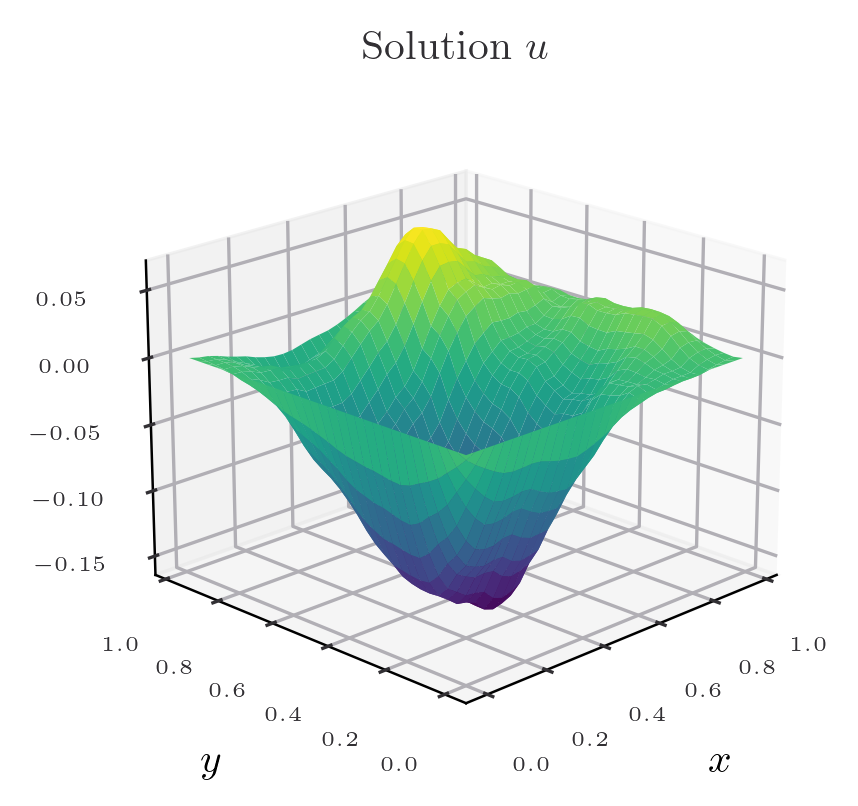

In [183]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_coarse,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Solution $u$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

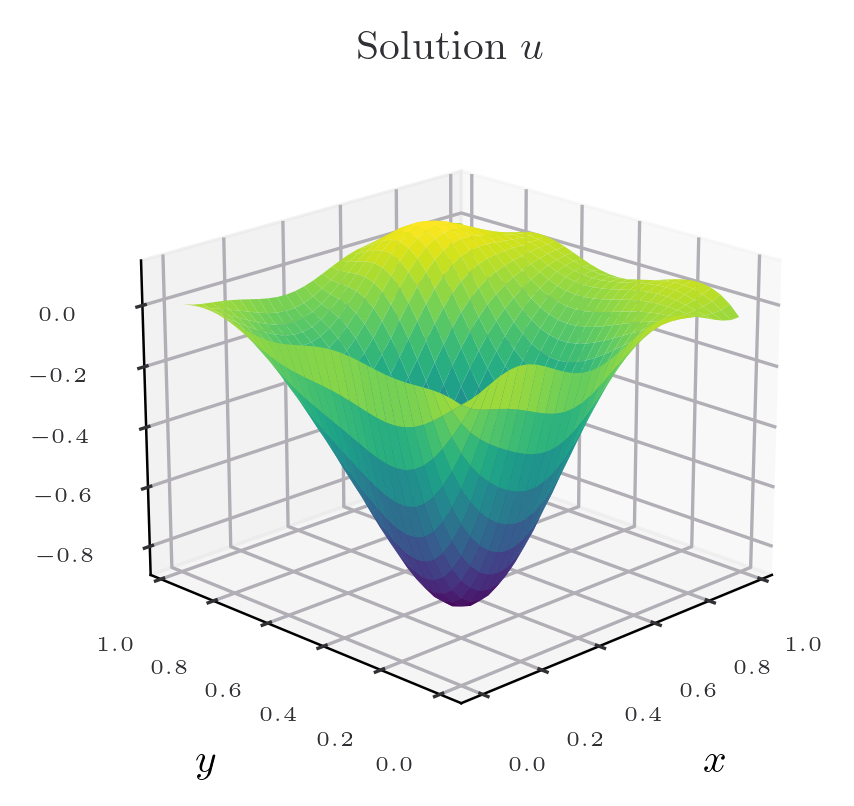

In [182]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, pred_grid,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Solution $u$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

# We will compute the DST in 2 dimensions

In [3]:
lower = 0.0
upper = 1.0
domain = jnp.array([lower,upper])

# 2d grid 
n_points = 4
x = jnp.linspace(lower, upper, n_points, endpoint=False)
y = jnp.linspace(lower+1, upper+1, n_points, endpoint=False)
X, Y = jnp.meshgrid(x, y)

In [4]:
x

Array([0.  , 0.25, 0.5 , 0.75], dtype=float64)

In [5]:
X.shape, Y

((4, 4),
 Array([[1.  , 1.  , 1.  , 1.  ],
        [1.25, 1.25, 1.25, 1.25],
        [1.5 , 1.5 , 1.5 , 1.5 ],
        [1.75, 1.75, 1.75, 1.75]], dtype=float64))

In [6]:
# Defining the second order elliptic operators 
def matern_kernel_2d(x_1, x_2, y_1, y_2, length_scale):
    r = jnp.sqrt((x_1 - y_1) ** 2 + (x_2 - y_2) ** 2)
    return (1 + jnp.sqrt(5)*r/length_scale + (5 / 3) * (r ** 2) / (length_scale ** 2)) * jnp.exp(-jnp.sqrt(5)*r/length_scale)

In [7]:
length_scale = 1.0
matern_kernel_tensor = jit(vmap(vmap(vmap(vmap(matern_kernel_2d, in_axes=(None, None,None, 0, None)), in_axes=(None, None, 0, None, None)), in_axes = (None, 0, None, None, None)), in_axes=(0, None, None, None, None)))

In [8]:
K_tensor = matern_kernel_tensor(x, x, y, y, length_scale)

In [9]:
# Checking that the tensor is correct
for i in range(n_points):
    for j in range(n_points):
        for k in range(n_points):
            for l in range(n_points):
                assert K_tensor[i,j,k,l] == matern_kernel_2d(x[i], x[j], y[k], y[l], length_scale)

In [10]:
# Testing the sine transform
def discrete_sine_transform(y):
    n = y.shape[0]
    y_extended = jnp.concatenate([y,  -y[::-1]])
    y_fft = fft.rfft(y_extended)
    return (-y_fft.imag/(jnp.sqrt(2)*(n)))[:-1] # Removing the last spurious element 

In [11]:
def vectorize_function(f, ndim):
    for _ in range(ndim):
        f = jax.vmap(f)
    return f

f_test = lambda x: x**2

f_test_vectorized = vectorize_function(f_test, 4)

In [12]:
K_test = f_test_vectorized(K_tensor)
# Checking that the tensor is correct
for i in range(n_points):
    for j in range(n_points):
        for k in range(n_points):
            for l in range(n_points):
                assert K_test[i,j,k,l] == f_test(K_tensor[i,j,k,l])


In [13]:
vmap_dst = jit(vmap(discrete_sine_transform, in_axes=(0,)))
@jit
def dst_2d(A):
    # Receives a 2d array and returns the 2d discrete sine transform
    return vmap_dst(vmap_dst(A).T).T

In [14]:
i,j = 0,2
dst_2d(K_tensor[i,j]).shape

(4, 4)

In [15]:
def test_function(A):
    return A**2

# Create a 4D tensor of size NxNxNxN
N = 4
tensor_4d = jnp.arange(N**4).reshape(N, N, N, N)
temp_tensor = vmap(vmap(test_function, in_axes=0, out_axes=0), in_axes=1, out_axes= 1)(tensor_4d)

In [16]:
for i in range(N):
    for j in range(N):
        #assert jnp.allclose(test_function(tensor_4d[i,j]), temp_tensor[i,j])
        print(jnp.mean(jnp.abs(test_function(tensor_4d[i,j])-temp_tensor[i,j])))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [17]:
i, j = 1,2

In [18]:
K_trans_1 = vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1)(K_tensor)
K_trans_1[i,j]

Array([[-0.        , -0.        , -0.        , -0.        ],
       [-0.        ,  0.22995764,  0.03764908,  0.03915226],
       [ 0.        ,  0.04809114,  0.01003593,  0.0083947 ],
       [-0.        ,  0.04098363,  0.00706518,  0.0070257 ]],      dtype=float64)

In [23]:
# CHecking our vmap
for i in range(n_points):
    for j in range(n_points):
        #print(jnp.mean(jnp.abs(K_trans_1[i,j]- dst_2d(K_tensor[i,j]))))
        assert jnp.allclose(K_trans_1[i,j], dst_2d(K_tensor[i,j]))


In [24]:
tensor_intermediate = vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1)
#dst_tensor = vmap(vmap(tensor_intermediate, in_axes=2, out_axes=2), in_axes=3,out_axes=3)(K_tensor)

In [25]:
jnp.swapaxes(K_tensor, 0, 1).shape

(4, 4, 4, 4)

In [26]:
K_tensor[0,1,2,3]

Array(0.11533482, dtype=float64)

In [27]:
jnp.transpose(K_tensor, (2, 3, 0, 1))[2,3,0,1]

Array(0.11533482, dtype=float64)

In [28]:
@jit
def double_dst_2d(A):
    # Transform along the last 2 axes
    A = vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1)(A)
    # Transpose the axes
    A = jnp.transpose(A, (2, 3, 0, 1))
    # Transform along the last 2 axes
    A = vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1)(A)
    # Transpose the axes (going back to the original order)
    A = jnp.transpose(A, (2, 3, 0,1))
    return A

In [29]:
K_tensor_transform = double_dst_2d(K_tensor)

In [30]:
tensor_intermediate = vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1)(K_tensor)
tensor_intermediate = jnp.transpose(tensor_intermediate, (2, 3, 0, 1))
tensor_intermediate = vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1)(tensor_intermediate)

In [31]:
i, j,k,l = 3,2,3,0

In [32]:
tensor_intermediate[k,l,i,j], K_tensor_transform[i,j,k,l]

(Array(-0., dtype=float64), Array(-0., dtype=float64))

In [33]:
[k,l,i,j]

[3, 0, 3, 2]

In [34]:
tensor_intermediate[i,j,k,l]

Array(-0., dtype=float64)

In [58]:
lower = 0.0
upper = 1.0
domain = jnp.array([lower,upper])

# 2d grid 
n_points = 64
x = jnp.linspace(lower, upper, n_points, endpoint=False)
y = jnp.linspace(lower, upper, n_points, endpoint=False)
X, Y = jnp.meshgrid(x, y)

In [59]:
K_tensor = matern_kernel_tensor(x, x, y, y, length_scale)

In [60]:
K_tensor.shape

(64, 64, 64, 64)

In [38]:
# def integrate_sine(points, k, l, K):
#      G = K*jnp.outer(jnp.sqrt(2)*jnp.sin(jnp.pi*k*points), jnp.sqrt(2)*jnp.sin(jnp.pi*l*points))
#      return integrate.trapezoid(integrate.trapezoid(G, points), points)

In [40]:
def create_sine(x,y,z,w, i,j,k,l):
    return jnp.sqrt(2)*jnp.sin(jnp.pi*i*x)*jnp.sqrt(2)*jnp.sin(jnp.pi*j*y)*jnp.sqrt(2)*jnp.sin(jnp.pi*k*z)*jnp.sqrt(2)*jnp.sin(jnp.pi*l*w)

create_sine_tensor = vmap(vmap(vmap(vmap(create_sine, in_axes = (None, None, None, 0, None, None, None, None)), in_axes = (None, None, 0, None, None, None, None, None)),  in_axes = (None, 0, None, None, None, None, None, None)), in_axes = (0, None, None, None, None, None, None, None))

In [55]:
from jax.scipy import integrate

In [79]:
i,j,k,l = 3, 3,3,3
sine_tensor = create_sine_tensor(x,x,y,y,i,j,k,l)
G = sine_tensor*K_tensor
integrate.trapezoid(integrate.trapezoid(integrate.trapezoid(integrate.trapezoid(G, y), y), x), x)

Array(0.00491721, dtype=float64)

In [80]:
K_tensor_transform = double_dst_2d(K_tensor)

In [81]:
K_tensor_transform[i,j,k,l]

Array(0.00502258, dtype=float64)

In [56]:
jnp.mean(G)

Array(0.0057384, dtype=float64)

In [51]:
m,n,o,p = 23,45, 7, 17
sine_tensor[m,n,o,p], create_sine(x[m],x[n],y[o],y[p], i,j,k,l)

(Array(0.57902026, dtype=float64), Array(0.57902026, dtype=float64))